In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from glob import glob
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
HEIGHT = WIDTH = 512
BATCH_SIZE = 64
EPOCHS = 20
TRAIN_PROP = 0.9
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

In [4]:
rem = [109, 123, 709]
df = df[~df.BraTS21ID.isin(rem)].reset_index(drop = True)

In [5]:
def full_ids(data):
    zeros = 5 - len(str(data))
    if zeros > 0:
        prefix = ''.join(['0' for i in range(zeros)])
    
    return prefix+str(data)
        

df['BraTS21ID_full'] = df['BraTS21ID'].apply(full_ids)

root_dir_train = "/kaggle/input/rsna-miccai-png/"

df['flair'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/FLAIR/')
df['t1w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T1w/')
df['t1wce'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T1wCE/')
df['t2w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T2w/')


In [6]:
def train_df(mri_type):
    all_img_files = []
    all_img_labels = []
    all_img_patient_ids = []
    for row in df.iterrows():
        
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.png', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.png' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+image for image in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_img_files.extend(img_paths)
        all_img_labels.extend(img_labels)
        all_img_patient_ids.extend(img_patient_ids)
        
    train_val_df = pd.DataFrame({'patient_ids': all_img_patient_ids,
                  'labels': all_img_labels,
                  'file_paths': all_img_files})
    
    classes_splits  = {}
    for i in range(2):
        train_val_label_class = train_val_df[train_val_df['labels']==i]
        train_val_list_ids =  list(train_val_label_class['patient_ids'].unique())
        train_threshold = math.ceil(TRAIN_PROP*len(train_val_list_ids))
        train_ids = train_val_list_ids[:train_threshold]
        val_ids = train_val_list_ids[train_threshold:]
        classes_splits[f'train_{i}'] = train_val_label_class[train_val_label_class['patient_ids'].isin(train_ids)]
        classes_splits[f'val_{i}'] = val_df = train_val_label_class[train_val_label_class['patient_ids'].isin(val_ids)]
        
    train_df = pd.concat([classes_splits['train_0'], classes_splits['train_1']], axis=0)
    val_df = pd.concat([classes_splits['val_0'], classes_splits['val_1']], axis=0)

    return train_df, val_df

In [7]:
train_val = []
for mri_type in ['flair', 't1w', 't1wce', 't2w']:
    train_val.append(train_df(mri_type))

In [8]:
@tf.function
def load_data(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image,channels=3)
    image = tf.image.resize(image, (HEIGHT,WIDTH)) / 255.0
    image = tf.expand_dims(image, axis=0)

    return(image,label)

In [9]:
def form_dataset(paths,labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
    
    dataset = (
        dataset
        .map(load_data, num_parallel_calls = AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    
    return dataset

In [10]:
train_val[1][0]

,patient_ids,labels,file_paths
6,3,0,/kaggle/input/rsna-miccai-png/train/00003/T1w/...
7,3,0,/kaggle/input/rsna-miccai-png/train/00003/T1w/...
8,3,0,/kaggle/input/rsna-miccai-png/train/00003/T1w/...
18,9,0,/kaggle/input/rsna-miccai-png/train/00009/T1w/...
19,9,0,/kaggle/input/rsna-miccai-png/train/00009/T1w/...
...,...,...,...
5635,773,1,/kaggle/input/rsna-miccai-png/train/00773/T1w/...
5636,773,1,/kaggle/input/rsna-miccai-png/train/00773/T1w/...
5637,773,1,/kaggle/input/rsna-miccai-png/train/00773/T1w/...
5638,773,1,/kaggle/input/rsna-miccai-png/train/00773/T1w/...


In [11]:
val_datasets = []

for data in train_val:
    val_datasets.append(
        form_dataset(
            data[1]["file_paths"],
            data[1]["labels"]
        )
    )

In [12]:
models = []

for mri_type in ['flair', 't1w', 't1wce', 't2w']:
    models.append(tf.keras.models.load_model(f"/kaggle/input/xception-mpmri-models/{mri_type}_model.h5"))

In [13]:
all_val_preds = []
val_dfs = []

for i, model_name in enumerate(['flair', 't1w', 't1wce', 't2w']):
    val_df = train_val[i][1]
    
    val_ds = val_datasets[i]
    model = models[i]
    
    val_pred = model.predict(val_ds, steps=len(val_ds))
    val_df["pred_y"] = val_pred
    
    val_dfs.append(val_df)
    
    mean_pred = val_pred.mean()
    test_pred_agg = val_df.groupby('patient_ids').apply(
        lambda x: x['pred_y'].max()
        if (x['pred_y'].max() - mean_pred) > (mean_pred - x['pred_y'].min()) 
        else x['pred_y'].min())
    all_val_preds.append(test_pred_agg.values)

267/267 [==============================] - 5s 15ms/step


In [14]:
val_df = val_dfs[0][["patient_ids","labels"]]
val_df = val_df.drop_duplicates().reset_index(drop=True)

In [15]:
all_val_preds = np.array(all_val_preds)
preds = all_val_preds.mean(0)

In [16]:
val_df["preds"] = preds

In [17]:
val_df["preds_binary"] = val_df["preds"] >= 0.5
val_df["preds_binary"] = val_df["preds_binary"].astype(int)

In [18]:
val_df

,patient_ids,labels,preds,preds_binary
0,778,0,0.591941,1
1,780,0,0.560559,1
2,788,0,0.554617,1
3,792,0,0.434062,0
4,796,0,0.468475,0
5,797,0,0.458698,0
6,799,0,0.480239,0
7,800,0,0.460017,0
8,802,0,0.459732,0
9,803,0,0.436905,0


In [19]:
labels = val_df["labels"]
preds = val_df["preds"]
binary_preds = val_df["preds_binary"]

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

cm = confusion_matrix(labels, binary_preds)

In [21]:
df_cm = pd.DataFrame(cm, index=['MGMT Absent', 'MGMT Present'], columns=['MGMT Absent', 'MGMT Present'])

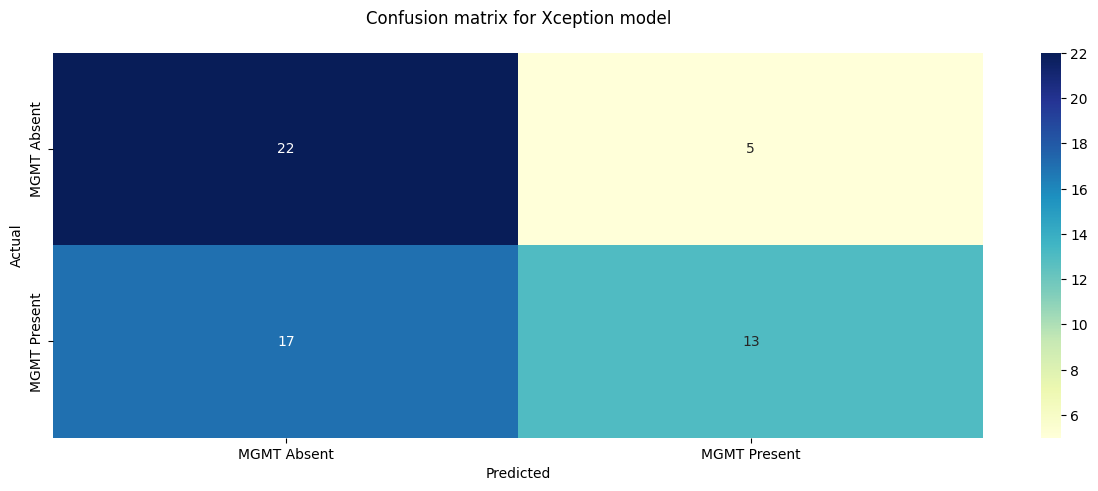

In [22]:
plt.figure(figsize=(15, 5))

plt.title("Confusion matrix for Xception model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

In [23]:
accuracy = accuracy_score(labels, binary_preds)
print(f"Model Accuracy Score: {accuracy}")

Model Accuracy Score: 0.6140350877192983


In [24]:
cr =classification_report(labels, binary_preds, target_names=['MGMT Absent', 'MGMT Present'])
print("Xception Model Classification Report")
print("=========================================")
print(cr)

Xception Model Classification Report
              precision    recall  f1-score   support

 MGMT Absent       0.56      0.81      0.67        27
MGMT Present       0.72      0.43      0.54        30

    accuracy                           0.61        57
   macro avg       0.64      0.62      0.60        57
weighted avg       0.65      0.61      0.60        57



In [25]:
print("Xception Model")
print("=========================================")
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f'MGMT Present : Sensitivity = {sensitivity}, Specificity = {specificity}')

Xception Model
MGMT Present : Sensitivity = 0.43333333333333335, Specificity = 0.8148148148148148


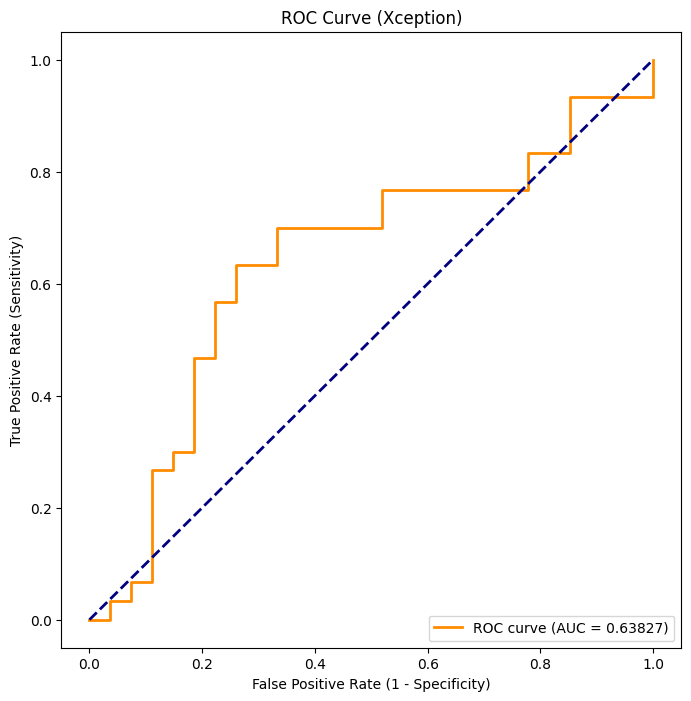

In [26]:
fpr, tpr, thresholds = roc_curve(labels, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve (Xception)')
plt.legend(loc='lower right')
plt.show()